<a href="https://colab.research.google.com/github/manikur/R-programming/blob/main/StockpriceITC_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance

In [5]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing,
 SimpleExpSmoothing,
 Holt)

In [14]:
df = yf.download('ITC.NS',
 start='2013-09-15',
 end='2021-09-16',
 adjusted=True,
 progress=False)

In [15]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-16,223.366669,226.000000,220.233337,222.633331,182.777664,10647888
2013-09-17,221.399994,226.533340,221.033340,225.800003,185.377457,6579115
2013-09-18,227.333328,230.000000,226.133331,229.033340,188.031967,10132803
2013-09-19,232.266663,237.666672,232.166672,236.966660,194.545059,14783796
2013-09-20,236.600006,238.666672,230.866669,236.866669,194.462952,12846751
...,...,...,...,...,...,...
2021-09-08,212.250000,213.000000,209.699997,211.250000,211.250000,17233315
2021-09-09,211.050003,213.899994,210.550003,212.649994,212.649994,19051252
2021-09-13,213.350006,215.149994,211.800003,214.149994,214.149994,16043896


In [17]:
itc = df.resample('M') \
 .last() \
 .rename(columns={'Adj Close': 'adj_close'}) \
 .adj_close

In [20]:
train_indices = itc.index.year < 2021
goog_train = itc[train_indices]
goog_test = itc[~train_indices]
test_length = len(goog_test)



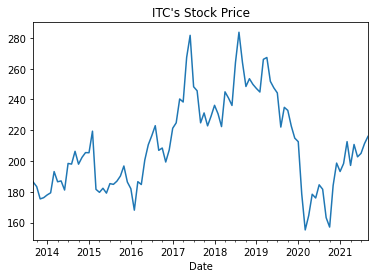

In [24]:
itc.plot(title="ITC's Stock Price");

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
from fbprophet import Prophet

In [49]:
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]


<Figure size 432x288 with 0 Axes>

In [31]:
ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)
ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)
ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

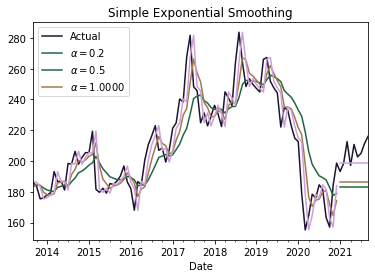

In [53]:
itc.plot(color=COLORS[0],
 title='Simple Exponential Smoothing',
 label='Actual',
 legend=True)
ses_forecast_1.plot(color=COLORS[1], legend=True,
 label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color=COLORS[1])
ses_forecast_2.plot(color=COLORS[2], legend=True,
 label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color=COLORS[2])
ses_forecast_3.plot(color=COLORS[3], legend=True,
 label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])





#Fit three variants of Holt's smoothing model and create forecasts:
# Holt's model with linear trend

In [40]:
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)
hs_2 = Holt(goog_train, exponential=True).fit()
hs_forecast_2 = hs_2.forecast(test_length)
hs_3 = Holt(goog_train, exponential=False,
 damped=True).fit(damping_slope=0.99)
hs_forecast_3 = hs_3.forecast(test_length)
Holt(goog_train, exponential=True)



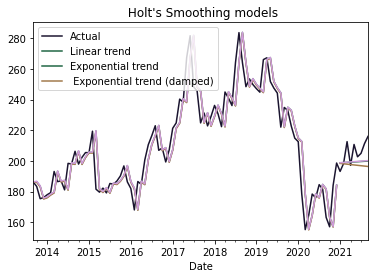

In [57]:
itc.plot(color=COLORS[0],
 title=" Holt's Smoothing models",
 label='Actual',
 legend=True)
hs_1.fittedvalues.plot(color=COLORS[1])
hs_forecast_1.plot(color=COLORS[1], legend=True,
 label='Linear trend')
hs_2.fittedvalues.plot(color=COLORS[2])
hs_forecast_2.plot(color=COLORS[2], legend=True,
 label='Exponential trend')
hs_3.fittedvalues.plot(color=COLORS[3])
hs_forecast_3.plot(color=COLORS[3], legend=True,
 label=' Exponential trend (damped)');



#Extension of Holt's method called Holt-Winter's Seasonal Smoothing this method is most suitable for data with trend and
seasonality. There are two variants of this model and they have either additive or multiplicative seasonalities

In [58]:
SEASONAL_PERIODS = 12

In [60]:
hw_1 = ExponentialSmoothing(goog_train,
 trend='mul',
 seasonal='add',
 seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)
hw_2 = ExponentialSmoothing(goog_train,
 trend='mul',
 seasonal='add',
 seasonal_periods=SEASONAL_PERIODS,
 damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)



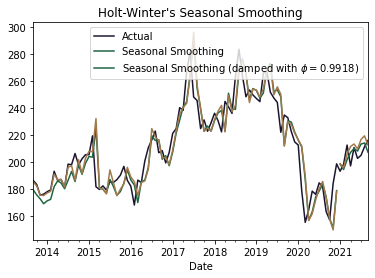

In [63]:
itc.plot(color=COLORS[0],
 title="Holt-Winter's Seasonal Smoothing",
 label='Actual',
 legend=True)
hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend=True,
 label='Seasonal Smoothing')
phi = hw_2.model.params['damping_slope']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'
hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True,
 label=plot_label)


Evaluate an ARIMA model using ITC weekly's stock price.

In [64]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs

In [65]:
df = yf.download('ITC.NS',
 start='2013-09-15',
 end='2021-09-16',
 adjusted=True,
 progress=False)

In [66]:
goog = df.resample('W') \
 .last() \
 .rename(columns={'Adj Close': 'adj_close'}) \
 .adj_close

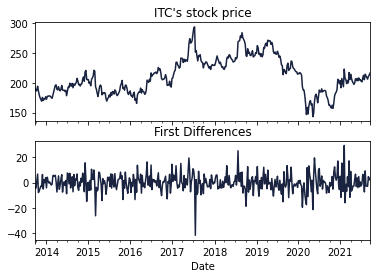

In [68]:
goog_diff = goog.diff().dropna()
fig, ax = plt.subplots(2, sharex=True)
goog.plot(title = "ITC's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

In [83]:
from chapter_3_utils import test_autocorrelation

ModuleNotFoundError: ignored

In [84]:
def adf_test(x):
 indices = ['Test Statistic', 'p-value',
 '# of Lags Used', '# of Observations Used']
 adf_test = adfuller(x, autolag='AIC')
 results = pd.Series(adf_test[0:4], index=indices)
 for key, value in adf_test[4].items():
     results[f'Critical Value ({key})'] = value
 return results

In [85]:
from pmdarima.arima import ndiffs, nsdiffs

ModuleNotFoundError: ignored

In [89]:
test_autocorrelation(goog_diff)


NameError: ignored

In [90]:
arima = ARIMA(goog, order=(2, 1, 1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  417
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1404.820
Method:                       css-mle   S.D. of innovations              7.013
Date:                Thu, 16 Sep 2021   AIC                           2819.640
Time:                        19:24:50   BIC                           2839.806
Sample:                    09-29-2013   HQIC                          2827.613
                         - 09-19-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0568      0.085      0.666      0.506      -0.110       0.224
ar.L1.D.adj_close     0.9160      0.049     18.740      0.000       0.820       1.012
ar.L2.D.adj_close     0.0583      0.049      1.193      0.233      -0.037       0.154
ma.L1.D.adj_close    -1.0000      0.007   -140.968      0.000      -1.014      -0.986
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0248           +0.0000j            1.0248            0.0000
AR.2          -16.7315           +0.0000j           16.7315            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [99]:
def arima_diagnostics(resids, n_lags=40):
 # create placeholder subplots
 fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
 r = resids
 resids = (r - np.nanmean(r)) / np.nanstd(r)
 resids_nonmissing = resids[~(np.isnan(resids))]
 sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
 ax1.set_title('Standardized residuals')
 x_lim = (-1.96 * 2, 1.96 * 2)
 r_range = np.linspace(x_lim[0], x_lim[1])
 norm_pdf = scs.norm.pdf(r_range)
 sns.distplot(resids_nonmissing, hist=True, kde=True,
 norm_hist=True, ax=ax2)
 ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
 ax2.set_title('Distribution of standardized residuals')
 ax2.set_xlim(x_lim)
 ax2.legend()
 qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
 ax3.set_title('Q-Q plot')
 plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
 ax4.set_title('ACF plot')
 return fig
 arima_diagnostics(arima.resid, 40)


[Text(0, 0.5, 'p-value'),
 Text(0.5, 0, 'Lag'),
 Text(0.5, 1.0, "Ljung-Box test's results")]

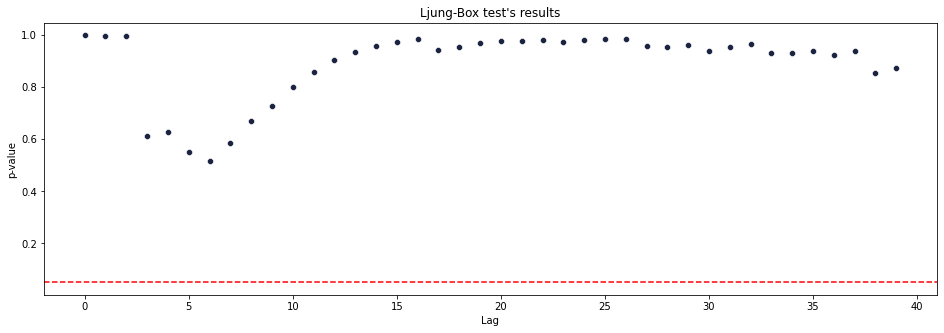

In [100]:
ljung_box_results = acorr_ljungbox(arima.resid)
fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])),
 y=ljung_box_results[1],
 ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
 xlabel='Lag',
 ylabel='p-value')


In [101]:
import pmdarima as pm

ModuleNotFoundError: ignored

In [102]:
n_forecasts = len(goog)

In [108]:
arima_pred = arima.forecast(n_forecasts)
arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
              pd.DataFrame(arima_pred[2], columns=['ci_lower',
 'ci_upper'])]



In [115]:
arima_pred = pd.concat(arima_pred,
                        axis=1).set_index(test.index)

NameError: ignored